In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://10.0.64.19/28231/1 Dashboard: http://localhost:45663/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [20]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWfutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWpastRun.nc')

In [21]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

## Finding max severity in future and past MHWs

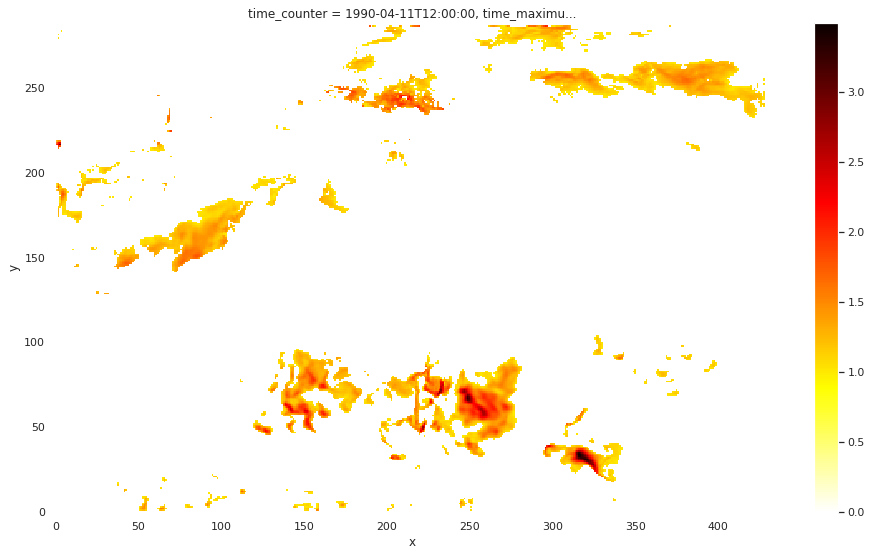

In [24]:
pastMHW.isel(time_counter = 100).plot(cmap = 'hot_r');

In [25]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk})

In [26]:
%%time 
maxFutSev = futMHW.max(dim = 'time_counter').compute()

CPU times: user 4.4 s, sys: 9.45 s, total: 13.8 s
Wall time: 10.2 s


In [27]:
%%time 
maxPastSev = pastMHW.max(dim = 'time_counter').compute()

CPU times: user 9.73 s, sys: 10.4 s, total: 20.1 s
Wall time: 44.8 s


In [28]:
# Replaces land masses with nan as opposed to 0 value
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

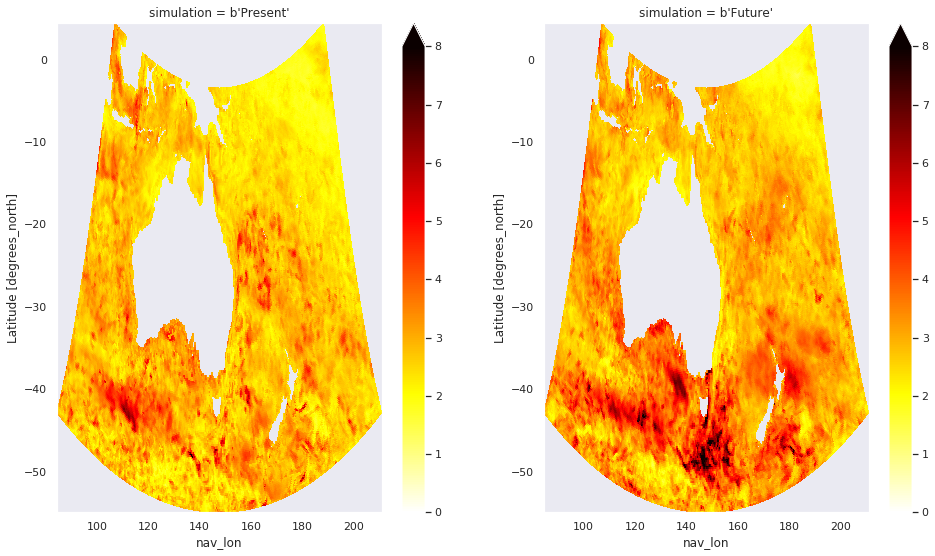

In [29]:
vmin = 0; vmax = 8;
f, (ax1, ax2) = plt.subplots(1, 2)
maxPastSev.isel(x = slice(5,-5), y = slice(5,-50)).plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSev.isel(x = slice(5,-5), y = slice(5,-50)).plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);

In [138]:
# Finding max SSTA - TO BE COMPLETED
ssta = sstFut.chunk({'x':50, 'y':50, 'time_counter':365}) - fClim.chunk({'x':50, 'y':50, 'time_counter':365})
maxFutSSTA = ssta.chunk({'x' : 200, 'y' : 200}).max(dim = 'time_counter').compute()
maxFutSSTA.isel(x = slice(5,-5), y= slice(5,-25)).plot(cmap = 'hot_r');

NameError: name 'sstFut' is not defined

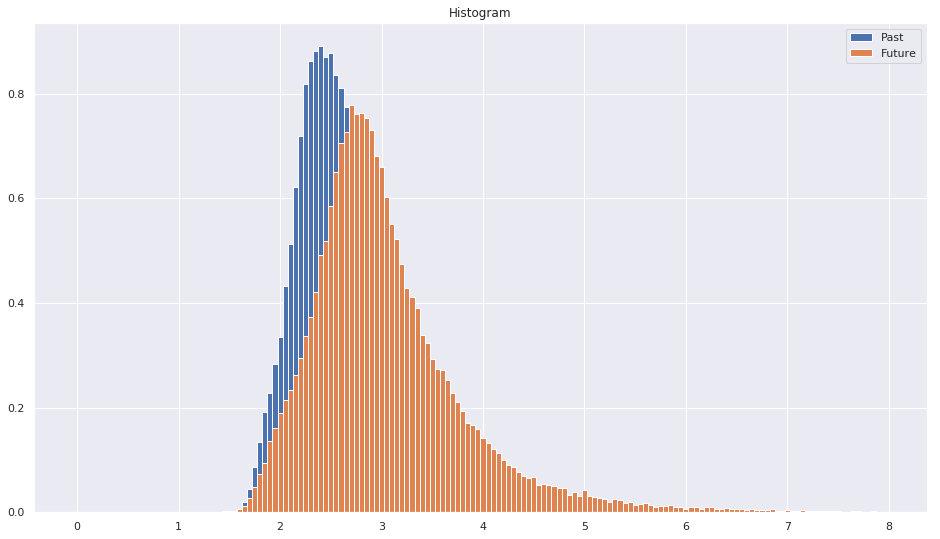

In [36]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,8,161)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

maxPastSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Past')#, ax = ax1);
maxFutSev.plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Future')#, ax = ax2);
plt.legend()
'''
ax1.set_title('Past Severity')
ax1.grid(True)
ax1.set_xlabel('Severity')

ax2.set_title('Future Severity');
ax2.grid(True);
ax2.set_xlabel('Severity');
''';

## Calculating statistics

In [34]:
# Calculating interquartile range
past_iqr = (maxPastSev.quantile(q = 0.75) - maxPastSev.quantile(q = 0.25)).data
fut_iqr = (maxFutSev.quantile(q = 0.75) - maxFutSev.quantile(q = 0.25)).data

In [35]:
# Comparing statistics
print("Past: std =", np.round(maxPastSev.std().data, 2), ", var =", np.round(maxPastSev.var().data,2),
      ", mean =", np.round(maxPastSev.mean().data,2), ", median =", np.round(maxPastSev.median().data,2),
     ", iqr =", np.round(past_iqr, 2))
print("Futu: std =", np.round(maxFutSev.std().data, 2), ", var =", np.round(maxFutSev.var().data,2),
     ", mean =", np.round(maxFutSev.mean().data,2),  ", median =", np.round(maxFutSev.median().data,2),
     ", iqr =", np.round(fut_iqr, 2))

Past: std = 0.62 , var = 0.38 , mean = 2.73 , median = 2.62 , iqr = 0.66
Futu: std = 0.83 , var = 0.69 , mean = 3.09 , median = 2.93 , iqr = 0.8


## Counting number of MHW days in each simulation

In [50]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
pastDays = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is mostly land
pastDays = xr.where(pastDays == 0, np.nan, pastDays).compute()

In [51]:
# Same as above
futDays = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
futDays = xr.where(futDays == 0, np.nan, futDays).compute()

In [52]:
print(futDays.sum().data/ pastDays.sum().data)
# Increase of 15% in MHW days!

1.1556337355079216


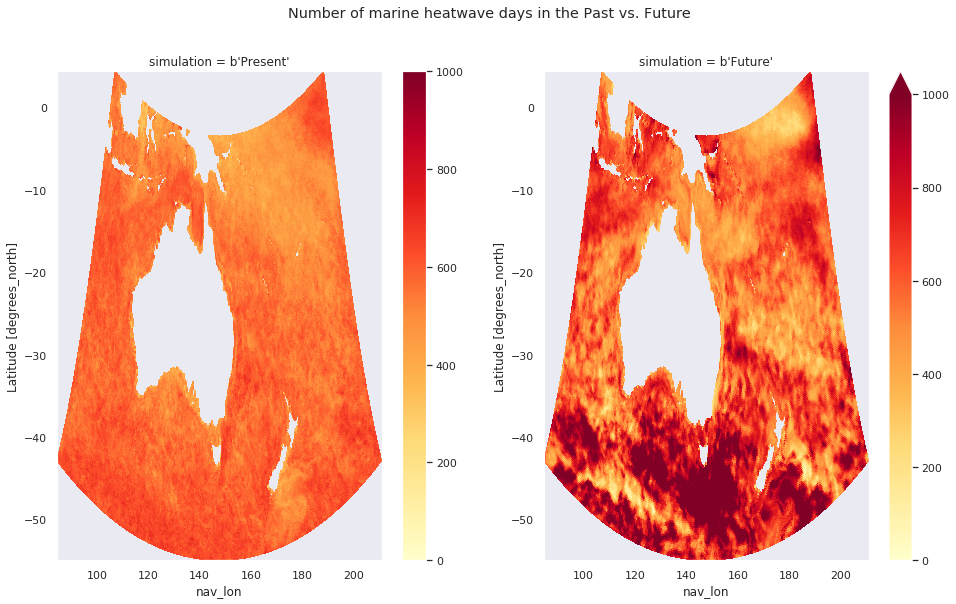

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2)
vmin, vmax = (0, 1000)
f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax1, vmin = vmin, vmax = vmax, cmap = 'YlOrRd');
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax2, vmin = vmin, vmax = vmax, cmap = 'YlOrRd');

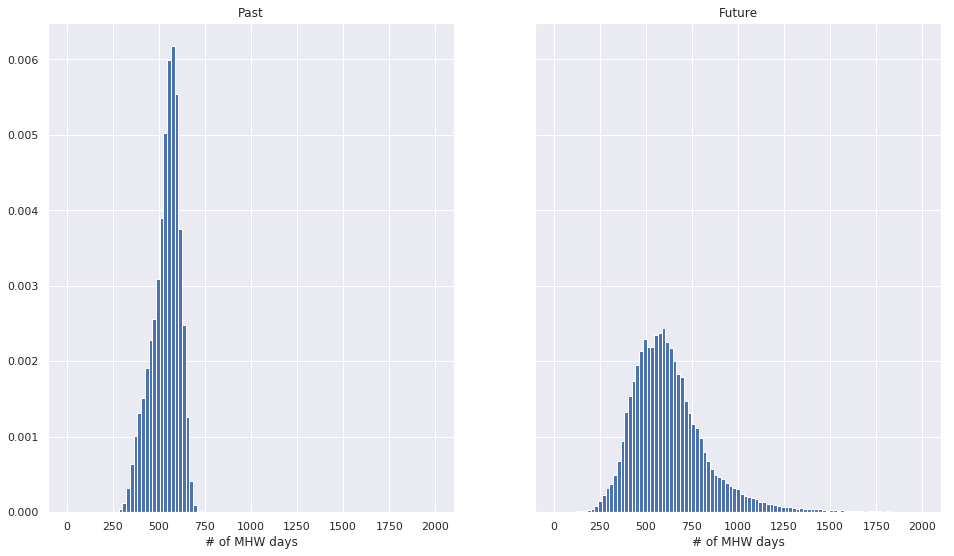

In [40]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,2000,100)

# True if plotting densities, false if you want just frequency
pltDens = True

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

pastDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Past', ax = ax1);
futDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Future', ax = ax2);
#plt.legend()

ax1.set_title('Past')
ax1.grid(True)
ax1.set_xlabel('# of MHW days')

ax2.set_title('Future');
ax2.grid(True);
ax2.set_xlabel('# of MHW days');

## Number of days and max severity plotted together

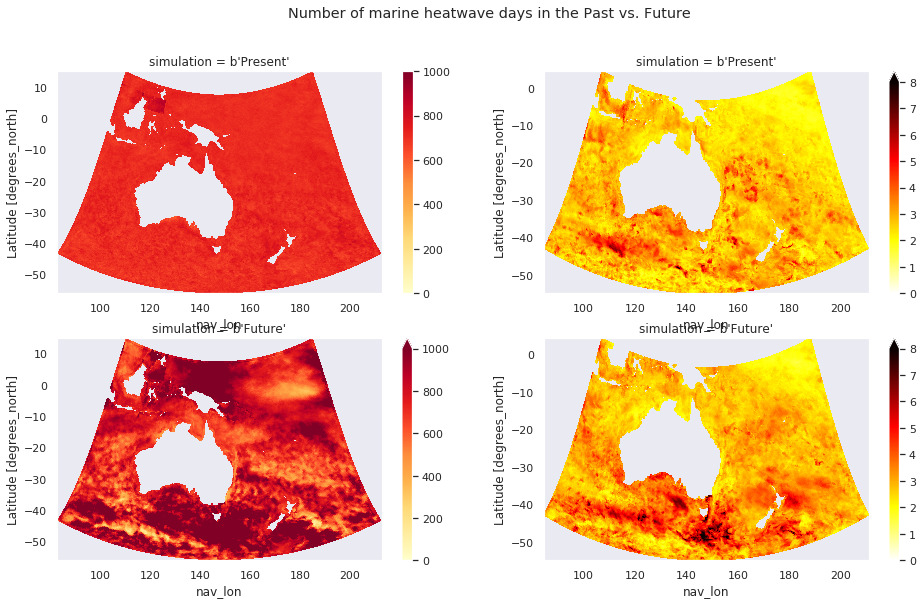

In [334]:
f, axs = plt.subplots(2, 2)
vmin1, vmax1 = (0, 1000)
vmin2, vmax2 = (0, 8);

f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = axs[0,0], vmin = vmin1, vmax = vmax1, cmap = 'YlOrRd');
maxPastSev.isel(x = slice(5,-5), y = slice(5,-50)).plot(cmap = 'hot_r', ax = axs[0,1], x = 'nav_lon', y = 'nav_lat', vmin = vmin2, vmax = vmax2);
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = axs[1,0], vmin = vmin1, vmax = vmax, cmap = 'YlOrRd');
maxFutSev.isel(x = slice(5,-5), y = slice(5,-50)).plot(cmap = 'hot_r',ax = axs[1,1], x = 'nav_lon', y = 'nav_lat', vmin = vmin2, vmax = vmax2);

In [328]:
axs[0,1]

## Calculating the difference in mixed layer depth

In [238]:
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
mld = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['mldr10_1']

In [239]:
mld_past = mld.sel(simulation = 'Present').chunk({'time_counter' : t_chunk, 'x' : x_chunk, 'y' : y_chunk})
mld_fut = mld.sel(simulation = 'Future').chunk({'time_counter' : t_chunk, 'x' : x_chunk, 'y' : y_chunk})

In [241]:
# Calculates the mean mld at each time step
spatialMean_past = mld_past.mean(dim = ('x','y'))
spatialMean_fut = mld_fut.mean(dim = ('x','y'))

In [243]:
spatialMean_past = spatialMean_past.compute()
spatialMean_fut = spatialMean_fut.compute()

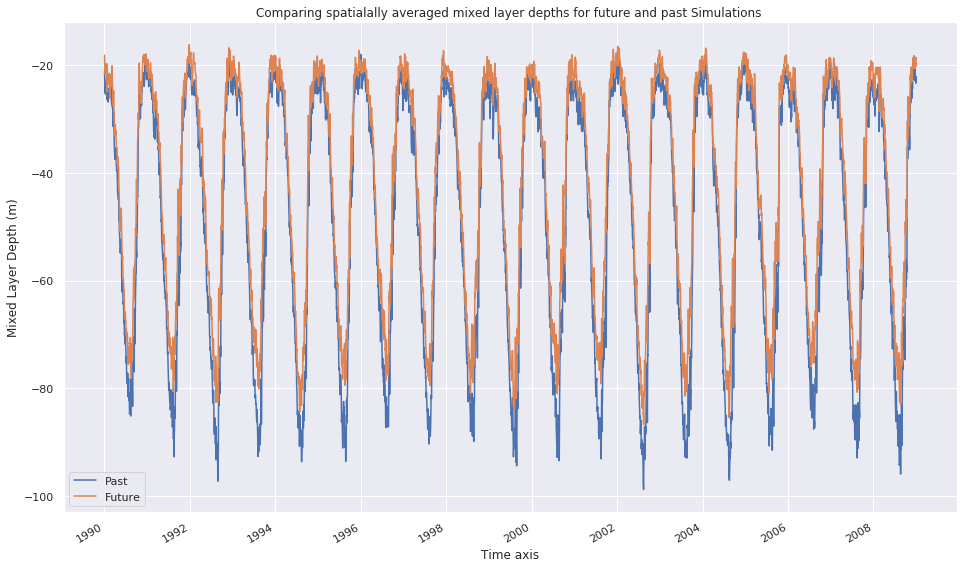

In [242]:
(-1*spatialMean_past).plot(label = 'Past');
(-1*spatialMean_fut).plot(label = 'Future');
plt.ylabel('Mixed Layer Depth (m)')
plt.title('Comparing spatialally averaged mixed layer depths for future and past Simulations ');
plt.legend();

In [245]:
# doy = day of year. Grouping together days of the year and averaging across them
doy_pastAve = spatialMean_past.groupby('time_counter.dayofyear').mean(dim = 'time_counter')
doy_futAve = spatialMean_fut.groupby('time_counter.dayofyear').mean(dim = 'time_counter')

In [247]:
# Rolling mean acts to smooth doy calculations
rollingMean_past = doy_pastAve.rolling(dayofyear = 11, center = True).mean().compute()
rollingMean_fut = doy_futAve.rolling(dayofyear = 11, center = True).mean().compute()

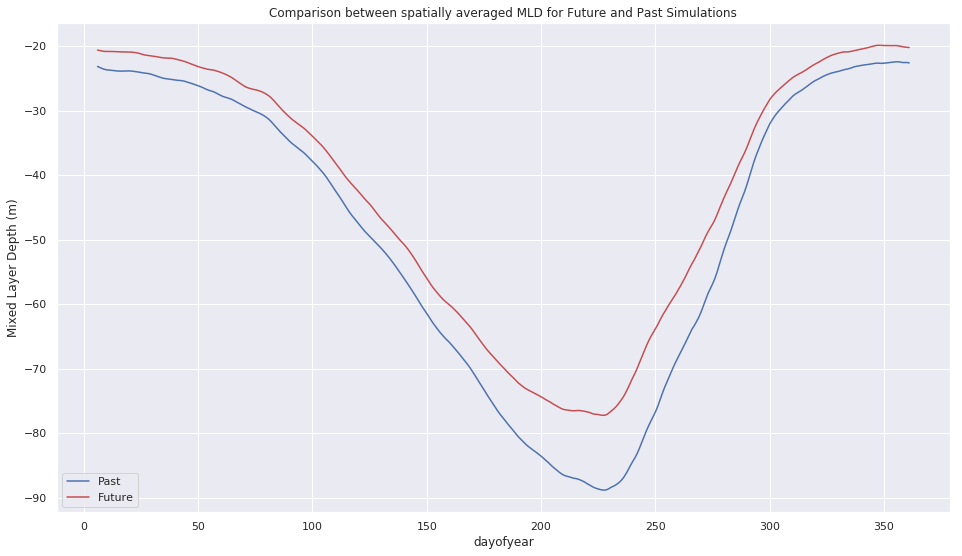

In [248]:
(-1*rollingMean_past).plot(color = 'b', label = 'Past');
(-1*rollingMean_fut).plot(color = 'r', label = 'Future');
plt.ylabel('Mixed Layer Depth (m)')
plt.title('Comparison between spatially averaged MLD for Future and Past Simulations')
plt.legend();
# Shows smaller MLD in the future!

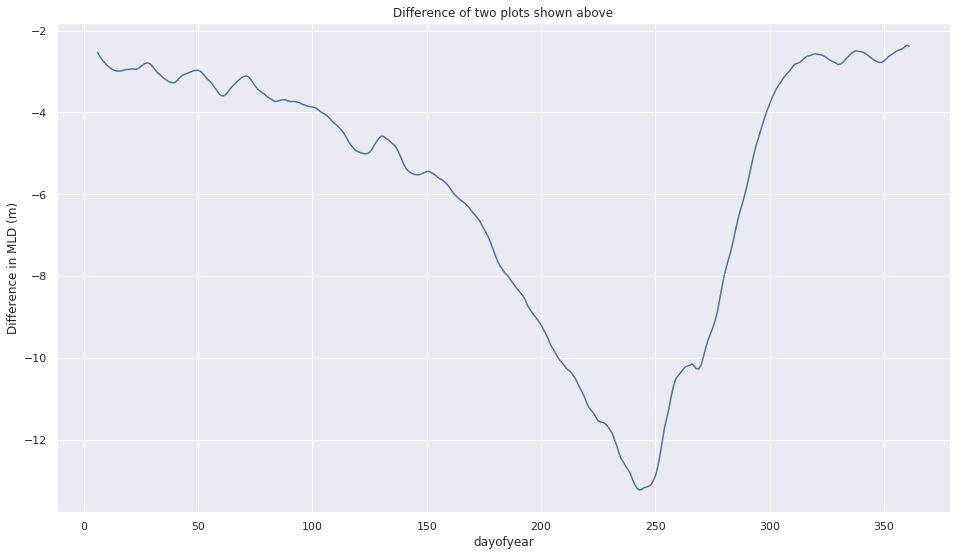

In [253]:
(rollingMean_fut - rollingMean_past).plot();
plt.title('Difference of two plots shown above')
plt.ylabel('Difference in MLD (m)');